# Problem Statement

[Food-101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/) is a challenging vision problem, but everyone can relate to it.  Recent SoTA is ~80% top-1, 90% top-5.  These approaches rely on lots of TTA, large networks and  even novel architectures.

Train a decent model >85% accuracy for top-1 for the test set, using a ResNet50 or smaller network with a reasonable set of augmentations. 

![sample image from dataset](/images/food-101.jpg "Food-101 sample images")



---

**Previous SoTA Results:**

Following is a comparison of the previous SoTA classification results for the Food-101 dataset.

| Model                    |  Augmentations           |  Epochs  |  Top-1 Accuracy  % |  Top-5 Accuracy %  |
| ------------------------|----------------------------------| --------------|------------------------------|------------------------------ |
| InceptionV3      | Flip, Rotation, Color, Zoom | 32   |                 88.28           |            96.88                 |
|WISeR                    | Flip, Rotation, Color, Zoom |  ~ 32   |               90.27    |           98.71                   |
| ResNet+fastai   | Optional Transformations |  16   |                 90.52           |            98.34                 |


---

**References:**

[1] **Inception V3 Approach** Hassannejad, Hamid, et al. [Food image recognition using very deep convolutional networks](https://dl.acm.org/citation.cfm?id=2986042). Proceedings of the 2nd International Workshop on Multimedia Assisted Dietary Management . ACM, 2016.

[2 ] **WISeR Approach** Martinel, Niki, Gian Luca Foresti, and Christian Micheloni. [Wide-slice residual networks for food recognition](https://arxiv.org/pdf/1612.06543.pdf) . Applications of Computer Vision (WACV), 2018 IEEE Winter Conference on . IEEE, 2018.

[3] **ResNet + fastai Approach** [platform.ai](https://platform.ai/blog/page/3/new-food-101-sota-with-fastai-and-platform-ais-fast-augmentation-search/) 




## Get data

In [0]:
#mount google drive in case we need to store data or transfer files

from google.colab import drive
drive.mount("/content/drive")
## %time !cp -R "data/food-101" "/content/drive/My Drive/Colab Notebooks/data/food-101"

Mounted at /content/drive


In [0]:
# copy if you want any pretrained models or export

# ! cp "/content/drive/My Drive/224_stage-2.pth" "/content/224_stage-2.pth"
# !cp "/content/drive/My Drive/Colab Notebooks/512_stage-1_2.pth" "/content/512_stage-1_2.pth"
# !cp "/content/drive/My Drive/Colab Notebooks/food-101/512_stage-2.pth" "/content/512_stage-2.pth"
# !cp "/content/drive/My Drive/Colab Notebooks/food-101/export.pkl" "/content/export.pkl"

In [0]:
# download data

# ! wget "http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz" -P {"data/"}
# ! tar -xf "data/food-101.tar.gz" -C "data/"

--2019-02-22 09:29:59--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2019-02-22 09:30:01--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘data/food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G   446KB/s    in 3h 9m   

2019-02-22 12:39:12 (430 KB/s) - ‘data/food-101.tar.gz’ saved [4996278331/4996278331]



Upload the data to drive so that we don't have to download it everytime (*specially in case of poor connections*) and have good upload speed.

If both are poor, *keep trying*.

In [0]:
# from google.colab import drive
# drive.mount("/content/drive")
# %time !cp -R "/content/drive/My Drive/Colab Notebooks/data/food-101" "data/food-101" 

# Food-101 

We will tackle this problem using two frameworks, (i) [Keras](http://keras.io/) (ii) [Fastai](https://docs.fast.ai/).
 
 We will use fastai(*awesome library*) in this notebook.
 
 ---
 
 ## Introduction
 
 Our objective is to classify 101,000 food images in 101 categories.
 
This is very so ImageNet like where we had 1.2  million images to classify into 1000 categories. There we saw explosion of different architectures starting from AlexNet, ZFNet, VGG, GoogLeNet, Inception v3, ResNet, SqueezeNet, and many other Nets to tackle this problem *better than humans*.
 

Now it's time to stand on shoulder of these Nets and use it to solve our classification problem into 101 food categories.

We have already seen a great length why **CNNs** are great at these jobs and we looked at many other things in [this blog](https://dudeperf3ct.github.io/cnn/mnist/2018/10/17/Force-of-Convolutional-Neural-Networks/).

---

## Our Approach

We will use ResNet50 as base architecture.


![resnet50](/images/resnet-50.png "ResNet50")


- We will add transformations like brightness, contrast, zoom, etc and resize all the images to size 224 for passing to the base architecture of ResNet50.
- Find a proper learning rate using LR Finder, an approach proposed by Leslie Smith in awesome paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). To further peeking in how it works, look [here](https://sgugger.github.io/the-1cycle-policy.html), [here](http://teleported.in/posts/cyclic-learning-rate/) and [here](https://www.jeremyjordan.me/nn-learning-rate/) and [Super-Convergence paper](https://arxiv.org/abs/1708.07120) .
- Train by keeping the weights of ResNet50 architecture (*excluding last FC layer*) fixed for 5 epochs.
- Unfreeze (*we can change the frozen weights of resnet50*), and train again for 4 epochs. This involves approach called discrimative fine-tuning(differential learning) which that the initial layers in CNN architectures better identify basic patterns like edge, textures and we don't wan't to drastically change that learning and hence very low learning rate, on other hand the final layers can be changed using higher learning rate. To see further, look [here](https://towardsdatascience.com/transfer-learning-using-differential-learning-rates-638455797f00), [here](https://towardsdatascience.com/transfer-learning-using-differential-learning-rates-638455797f00).
- Then, we will change the size of images from 224 to 512. (*Wooh bigger images*) and use the same model above train further.
- Again we approach the same methods above, freeze for 4 epochs and unfreeze and train for 3 epochs.


*Simple Enough?*

What result do we obtain after going through all this? Let's have a look

All results obtained are using Google Colab(*thanks Google!*).


|  Phase                       |   Time Taken (hrs)          |  Epochs  |  Top-1 Accuracy  % |  Top-5 Accuracy %  |
| ------------------------     |----------------------------------| --------------|------------------------------|------------------------------ |
| Freeze and Train on 224 size images  |  4 | 5   |                 75           |            92.36                |
|  Unfreeze and Train on 224 size images | 4  |  4   |               85    |           95.11                   |
|  Freeze and Train on 512 size images  | 7 |  4  |                 70          |            90.24                 |
|  Unfreeze and Train on 512 size images  | 7 |  3 |                 83           |            95.98                 |

---

**Conclusion**

*Phew!* 

**A lot of patience** - 22 hrs (*and dealing with colab is not easy, poor connections will lead to always disconnecting and 12 hrs timeout*)

**Very Cool Classifier** - Top-1 Accuracy = 83% and Top-5 Accuracy = 96%

---

**Improvements**

Results can further be improved

- Train longer (*as always, I need more power*)
- Experimenting with more transformations like skewness, jitter, etc can lead to more roubstness

---

*Don't forget to check out the blog in case you need a refresher on CNN, Transfer Learning and Visualizing CNN.*

Link: 

[1] [CNNs](https://dudeperf3ct.github.io/cnn/mnist/2018/10/17/Force-of-Convolutional-Neural-Networks/).

[2] [Transfer Learning](https://dudeperf3ct.github.io/transfer/learning/catsvsdogs/2018/11/20/Power-of-Transfer-Learning/).

[3] [Visualizing CNN](https://dudeperf3ct.github.io/visualize/cnn/catsvsdogs/2018/12/02/Power-of-Visualizing-Convolution-Neural-Networks/).


## Fastai

In [0]:
# import required libraries

from fastai.vision import *
import numpy as np
import os
from pathlib import Path

In [0]:
# path to dataset

path = Path('data/food-101/images/').resolve()

In [0]:
# we will apply transformations such as lightining, zoom, changing brightness and
# changing contrast and resizing it to size 224 which is required for resnet50

tfms = get_transforms(do_flip=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.2,
                      xtra_tfms=[brightness(change=(0.5*(1-0.1), 0.5*(1+0.1)), p=0.75),
                                 contrast(scale=(1-0.1, 1/(1-0.1)), p=0.75)])

# batch size
bs = 64

In [0]:
# fastai datablock

src = (ImageItemList.from_folder(path)
       .random_split_by_pct(0.2)
       .label_from_folder())

In [0]:
# create databunch

data = (src.transform(tfms, size=224)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

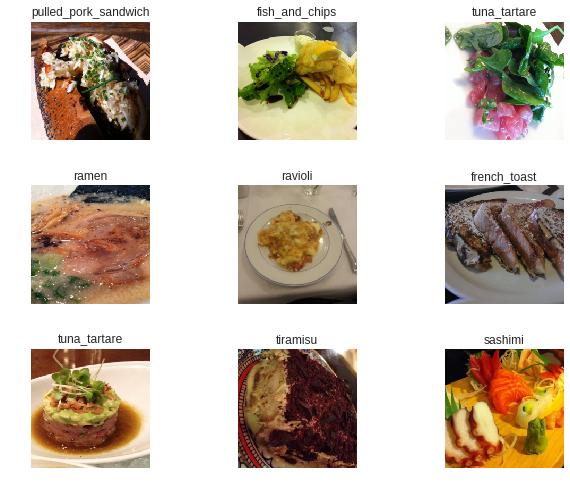

In [0]:
# show me sample images from dataset

data.show_batch(rows=3, figsize=(9, 7))

In [0]:
# print all the classes and number of classes

print(data.classes)
len(data.classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

101

## Model

In [0]:
# create a resnet50 architecture with metrics like top-1 accuracy and top-5 accuracy

learn = create_cnn(data, models.resnet50, metrics=[error_rate, accuracy, top_k_accuracy])
learn.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


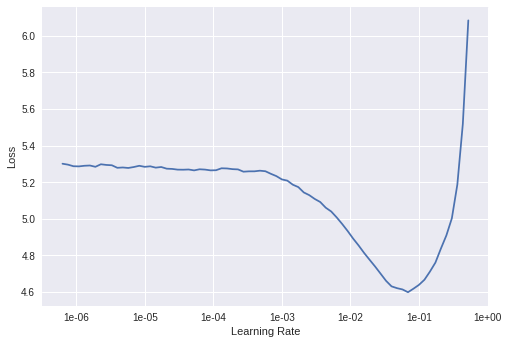

In [0]:
# Step 1: freeze and find learning rate, in this case we choose lr=1e-2

learn.lr_find()
learn.recorder.plot()

In [0]:
# using Cycle policy in super-convergence method, we fit using lr
# obtained from above result for 5 epochs

lr = 1e-2
learn.fit_one_cycle(5, slice(lr))

In [0]:
# save the trained model if you don't wan't to redo everything again!

learn.save('/content/224_stage-1.pth')

In [0]:
# create a backup by copying the saved model to google drive! 
# precaution is better than no caution!

%time !cp "/content/224_stage-1.pth" "/content/drive/My Drive/Colab Notebooks/224_stage-1.pth"

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


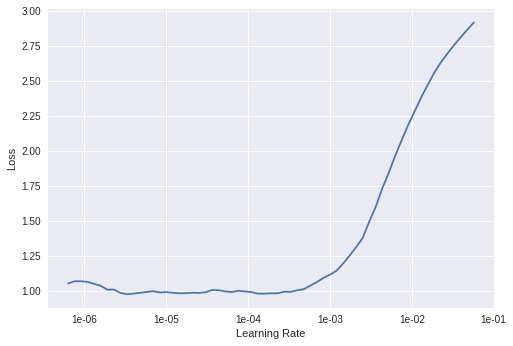

In [0]:
# Step 2: unfreeze and train

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# using cycle policy in super-convergence method we train for 4 epochs

learn.fit_one_cycle(4, slice(1e-5, lr/5))

In [0]:
# save the trained model if you don't wan't to redo everything again!

learn.save('/content/224_stage-2')

In [0]:
# create a backup by copying the saved model to google drive! 
# precaution is better than no caution!

%time !cp "/content/224_stage-2.pth" "/content/drive/My Drive/Colab Notebooks/224_stage-2.pth"

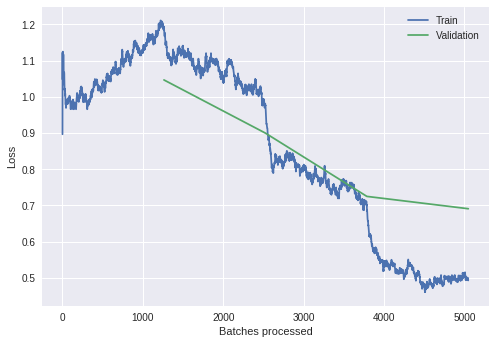

In [0]:
# plot the losses as we can see there is lot of noise in train
# that is due to training on mini-batches and it follows the
# expected trend of train loss less than validation loss 

learn.recorder.plot_losses()

In [0]:
# there comes our time out of google colab and fortunately as we had saved our 
# trained model we can load it again to train further

learn = create_cnn(data, models.resnet50, metrics=[error_rate, accuracy, top_k_accuracy]).load('/content/224_stage-2')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:03, 29109126.59it/s]


In [0]:
# we reduce the batch size as the size of images will be larger
# change the size from 224 to 512 and load the data in our trained model

bs = bs // 4

data = (src.transform(tfms, size=512)
        .databunch(bs=bs).normalize(imagenet_stats))

learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06


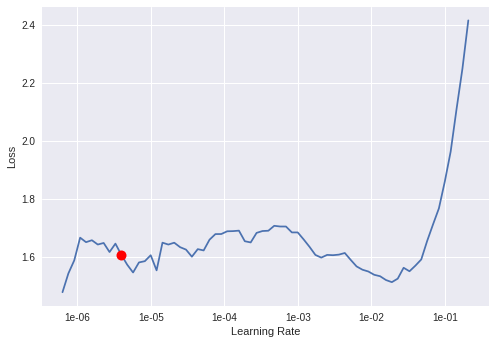

In [0]:
# Step 3: Freeze and train on 512 size images
# We again follow the same lr find method and obtain lr = 3.98E-06

learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# train model for 2 epochs it takes longer time to run than previous
# we don't want our work and time to count for nothing
# better to break 4 epochs into 2 save model and train for 2 again

lr = 3.98E-06
learn.fit_one_cycle(2, slice(lr))

In [0]:
# save model

learn.save('/content/512_stage-1_1')

In [0]:
# copy model to google drive

%time !cp "/content/512_stage-1_1.pth" "/content/drive/My Drive/Colab Notebooks/512_stage-1_1.pth"

CPU times: user 171 ms, sys: 42.2 ms, total: 213 ms
Wall time: 15.2 s


In [0]:
# train remaining 2 epochs

learn.fit_one_cycle(2, slice(lr))

In [0]:
# save model

learn.save('/content/512_stage-1_2')

In [0]:
# copy the trained model to google drive

%time !cp "/content/512_stage-1_2.pth" "/content/drive/My Drive/Colab Notebooks/512_stage-1_2.pth"

CPU times: user 106 ms, sys: 45.5 ms, total: 151 ms
Wall time: 15.2 s


In [0]:
# google colab died
# after bringing it back alive we start with loading a trained model from
# previous freeze model trained on 512 size images for 4 epochs

bs = bs // 4

data = (src.transform(tfms, size=512)
        .databunch(bs=bs).normalize(imagenet_stats))

learn = create_cnn(data, models.resnet50, metrics=[error_rate, accuracy, top_k_accuracy]).load('/content/512_stage-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


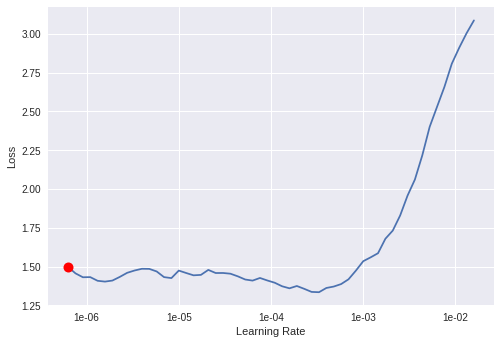

In [0]:
# Step 4: Unfreeze and train

learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
# Phew! finally last 3 epochs to complete the training procedure

lr = 3.98E-06
learn.fit_one_cycle(3, slice(1e-6, lr/5))

In [0]:
# save model in case we need it for inference

learn.save('/content/512_stage-2')

In [0]:
# as always take precaution by creating a copy

%time !cp "/content/512_stage-2.pth" "/content/drive/My Drive/Colab Notebooks/512_stage-2.pth"

CPU times: user 119 ms, sys: 43 ms, total: 162 ms
Wall time: 15.2 s


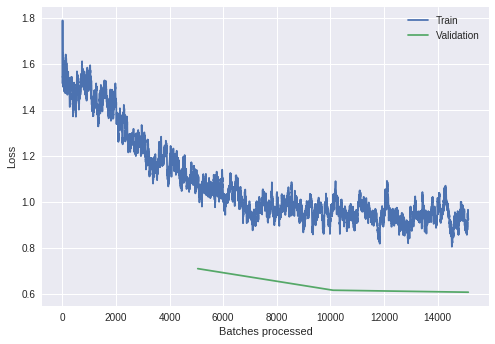

In [0]:
# wow, look at the curves

learn.recorder.plot_losses()

In [0]:
# fancy method in fastai to export all the classes and model architecture
# to file 'export.pkl'

learn.export()

In [0]:
# create a copy of that too!

%time !cp {path}"/export.pkl" "/content/drive/My Drive/Colab Notebooks/food-101/export.pkl"

CPU times: user 21 ms, sys: 44.5 ms, total: 65.5 ms
Wall time: 2.72 s


In [0]:
# load export.pkl by specifying the path where export.pkl is located

learn = load_learner(Path("/content/"))

## Interplotion

In [0]:
# yay! show me what you learned
# tta is fancy method called test time augmentation

interp = ClassificationInterpretation.from_learner(learn, tta=True)

losses,idxs = interp.top_losses()

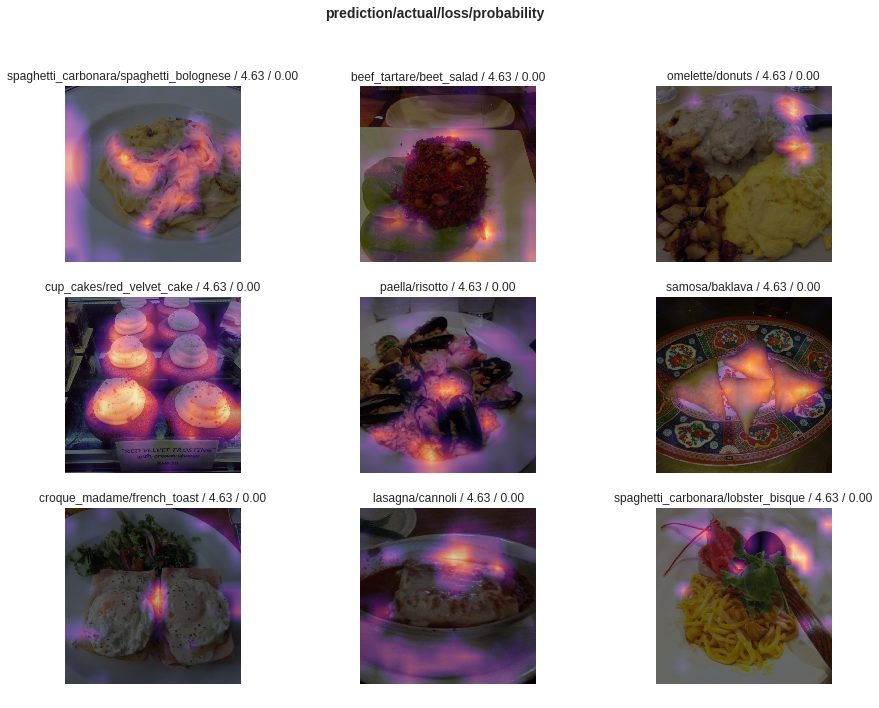

In [0]:
# ahh, the heatmaps!
# we say: tell me where were you looking at to make such prediction
# model replies: I was looking in these areas

interp.plot_top_losses(9, figsize=(15,11))

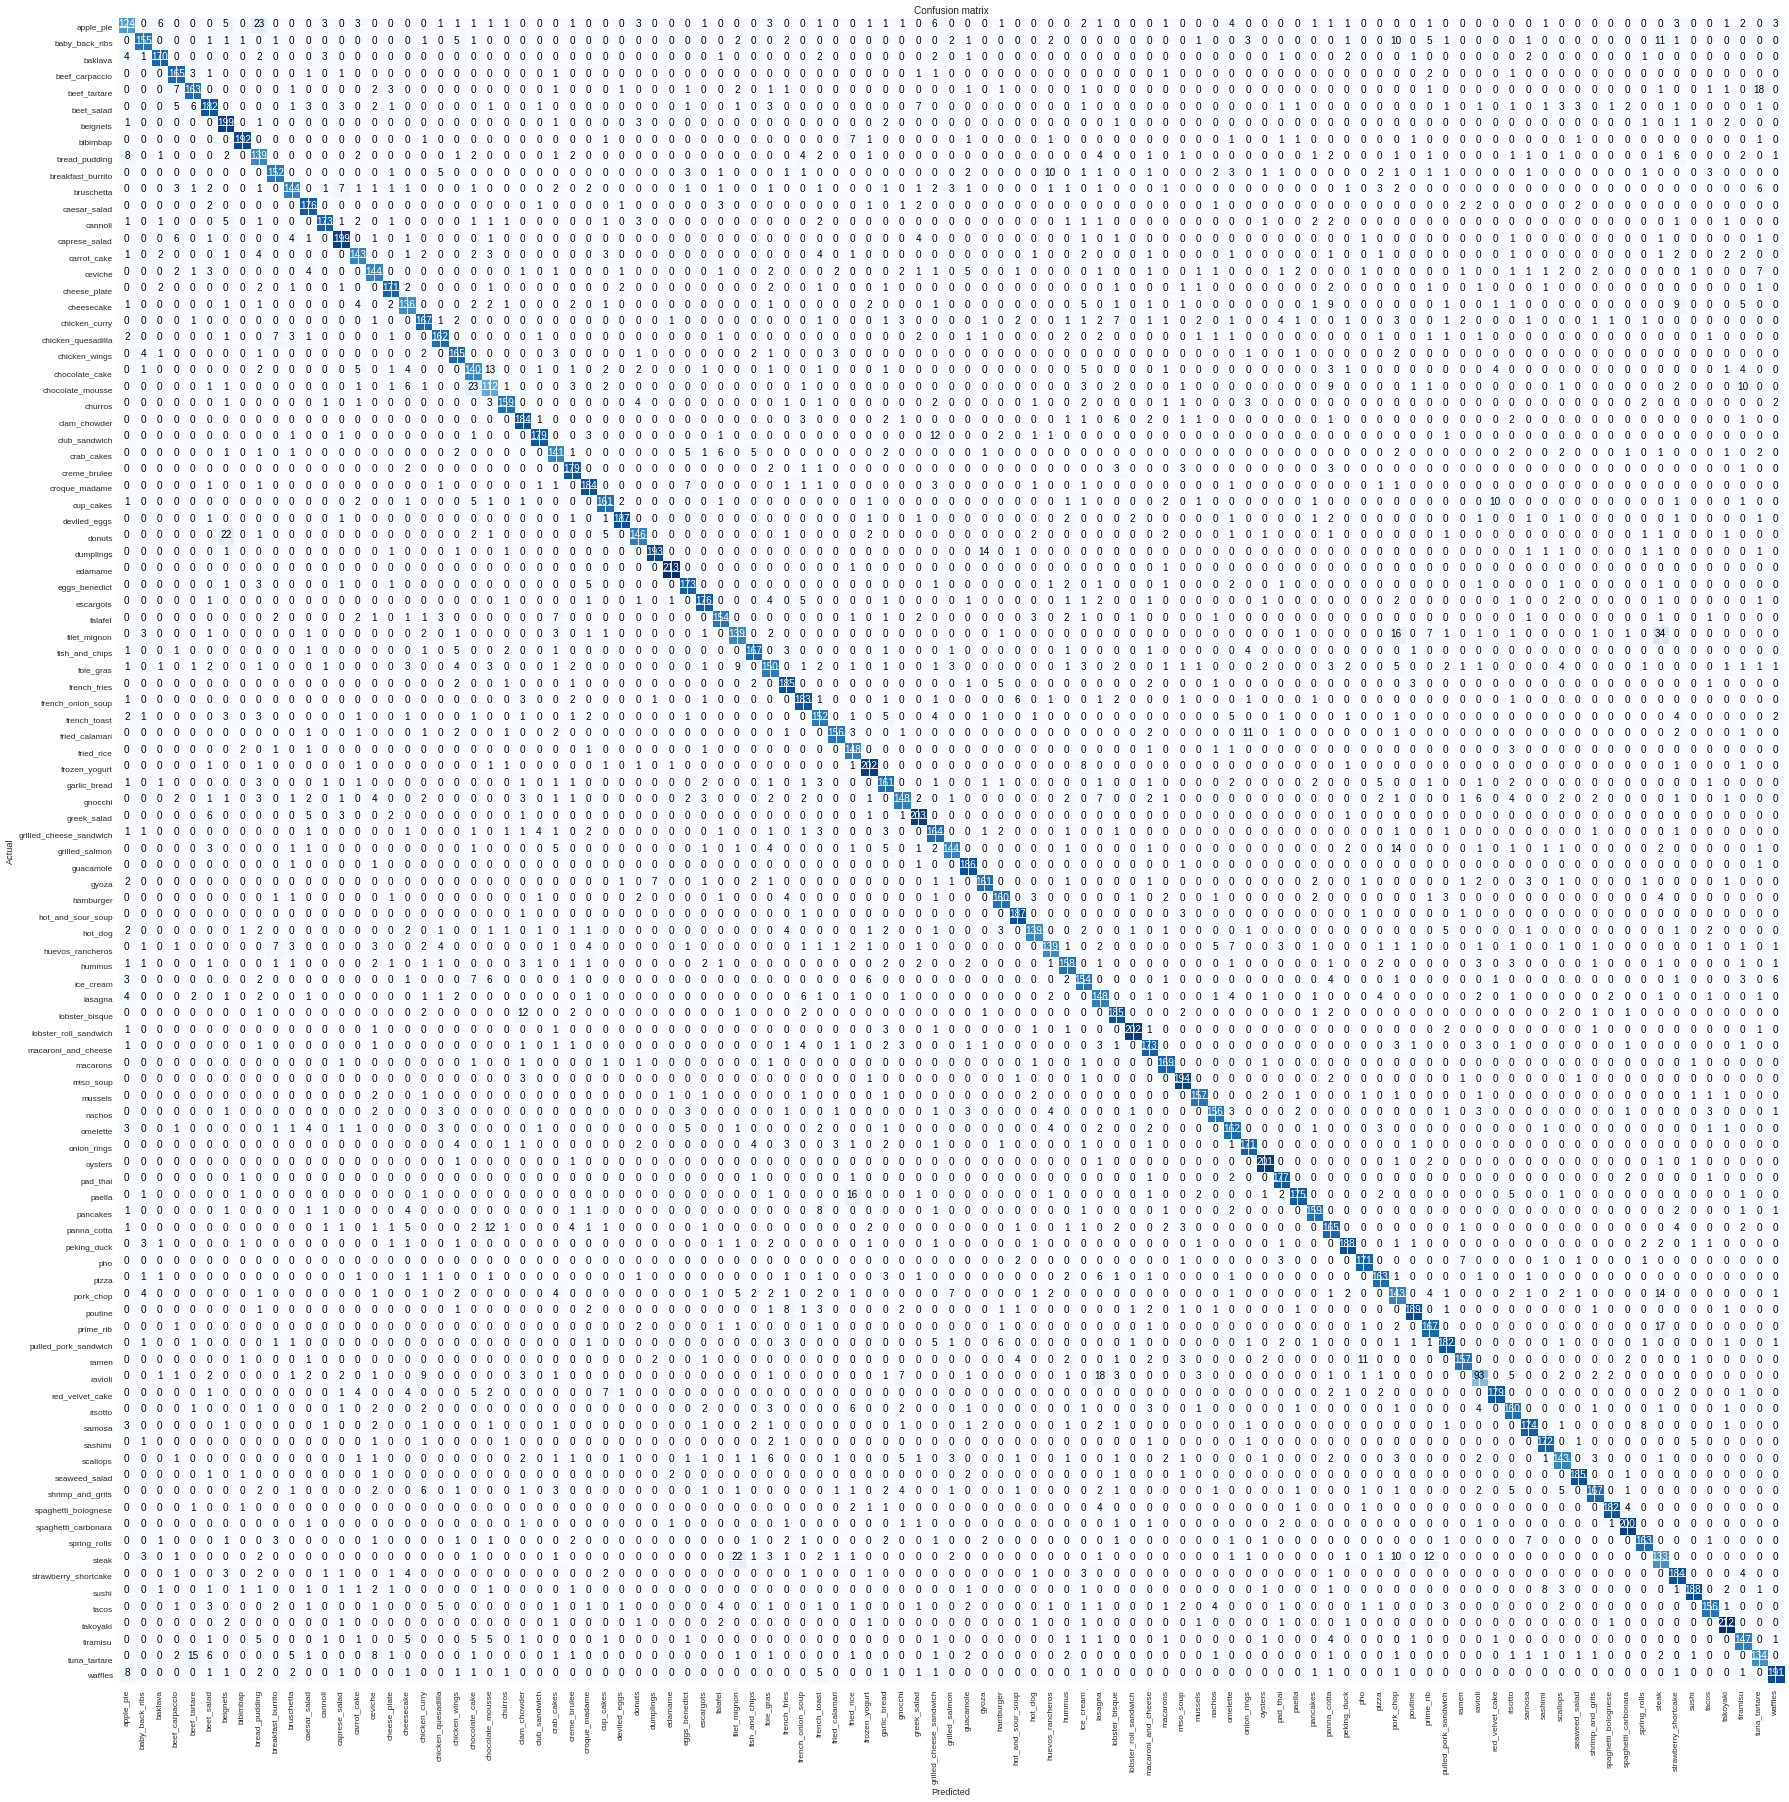

In [0]:
# how is the confusion in the confusion matrix?

interp.plot_confusion_matrix(figsize=(30, 30), dpi=60)

In [0]:
# where was the model more prone to make mistakes?
# which two classes are creating confusing more and more?

interp.most_confused(min_val=2)

[('filet_mignon', 'steak', 34),
 ('apple_pie', 'bread_pudding', 23),
 ('chocolate_mousse', 'chocolate_cake', 23),
 ('donuts', 'beignets', 22),
 ('steak', 'filet_mignon', 22),
 ('beef_tartare', 'tuna_tartare', 18),
 ('ravioli', 'lasagna', 18),
 ('prime_rib', 'steak', 17),
 ('filet_mignon', 'pork_chop', 16),
 ('paella', 'fried_rice', 16),
 ('tuna_tartare', 'beef_tartare', 15),
 ('dumplings', 'gyoza', 14),
 ('grilled_salmon', 'pork_chop', 14),
 ('pork_chop', 'steak', 14),
 ('chocolate_cake', 'chocolate_mousse', 13),
 ('club_sandwich', 'grilled_cheese_sandwich', 12),
 ('lobster_bisque', 'clam_chowder', 12),
 ('panna_cotta', 'chocolate_mousse', 12),
 ('steak', 'prime_rib', 12),
 ('baby_back_ribs', 'steak', 11),
 ('fried_calamari', 'onion_rings', 11),
 ('ramen', 'pho', 11),
 ('baby_back_ribs', 'pork_chop', 10),
 ('breakfast_burrito', 'huevos_rancheros', 10),
 ('chocolate_mousse', 'tiramisu', 10),
 ('cup_cakes', 'red_velvet_cake', 10),
 ('steak', 'pork_chop', 10),
 ('cheesecake', 'panna_cotta

## Testing 

(Category crab_cakes,
 tensor(26),
 tensor([1.4775e-04, 1.3299e-04, 5.2471e-06, 9.0113e-05, 7.2981e-03, 3.4285e-04,
         8.3388e-06, 3.3129e-03, 3.0927e-03, 1.6358e-03, 2.2066e-03, 1.6412e-03,
         1.2100e-05, 1.4068e-04, 9.7533e-04, 3.6194e-04, 2.9623e-04, 7.9109e-06,
         2.2657e-04, 1.7768e-05, 5.0890e-04, 2.5958e-06, 5.8511e-06, 4.3926e-06,
         3.8623e-04, 1.2492e-03, 5.6443e-01, 1.4657e-06, 1.2284e-01, 4.0476e-06,
         7.3861e-05, 2.6451e-06, 7.5543e-05, 2.8326e-05, 4.3145e-02, 6.6248e-05,
         3.7011e-04, 1.3788e-02, 5.3462e-03, 3.9676e-04, 5.4070e-04, 2.1474e-04,
         7.5665e-04, 1.9600e-03, 9.7891e-04, 3.9490e-05, 5.4556e-05, 1.0108e-03,
         8.8960e-05, 1.4730e-02, 2.8067e-02, 1.0460e-06, 5.2287e-05, 2.3650e-03,
         5.3391e-06, 1.5313e-04, 1.0432e-03, 2.3162e-05, 2.9301e-06, 7.7560e-03,
         2.2630e-04, 1.8352e-02, 3.5589e-03, 1.2446e-05, 1.0366e-06, 2.4279e-04,
         3.1925e-05, 6.3362e-02, 3.1887e-05, 7.0877e-05, 1.0985e-02, 1.293

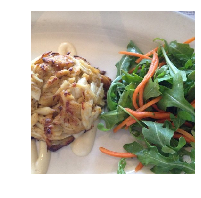

In [0]:
# testing time yay!
# show me an example from validation set
# wow! it got it right, that's a crab cake, Bingo!

img = data.valid_ds[0][0]
img.show()
learn.predict(img), learn.data.classes[26]

In [0]:
learn.data.classes

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot_and_sour_soup',
  'hot_dog',
  'huevos_rancheros',
  'hummu

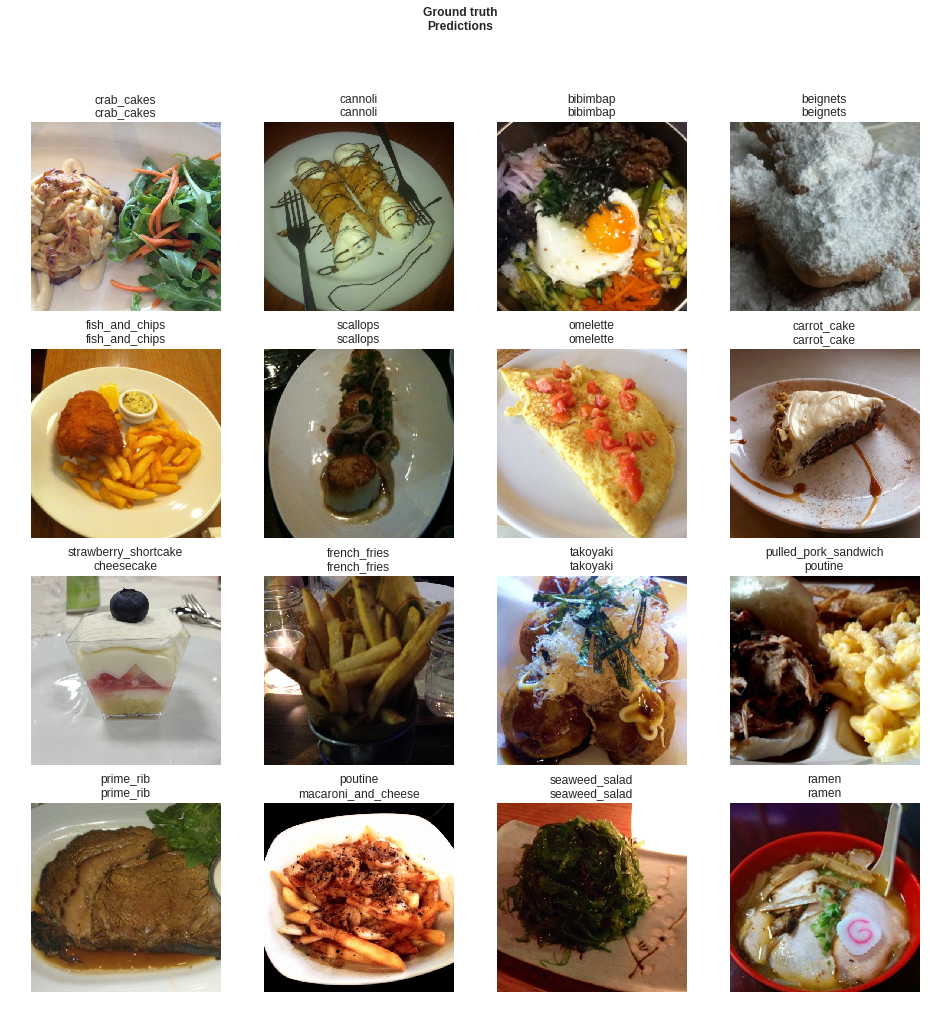

In [0]:
# show me sample results
# how well it matches with predictions and ground truth

learn.show_results(rows=5)

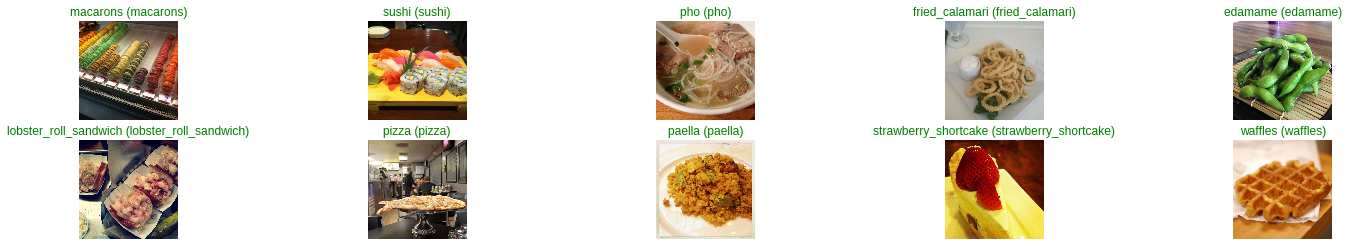

In [0]:
# classes
labels = learn.data.classes

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    img = data.valid_ds[idx+np.random.randint(0, len(data.valid_ds)-10)][0]
    preds = learn.predict(img)
    img.show(ax=ax)
    ax.set_title("{} ({})".format(str(learn.data.classes[preds[1]]), str(preds[0])),
                 color=("green" if str(learn.data.classes[preds[1]])==str(preds[0]) else "red"))

## Custom Images

You can test on give data all you want!

We need some testing on images taken from Google.

In [0]:
# copy if any test images are to be tested

%time !cp -R "/content/drive/My Drive/Colab Notebooks/food-101/test" "/content"

CPU times: user 43.8 ms, sys: 26.5 ms, total: 70.3 ms
Wall time: 5.18 s


In [0]:
# print all files in test path

test_path = Path("/content/test")
print (os.listdir(test_path))

['test_3.jpg', 'test_2.jpg', 'test_1.jpg', 'test_4.jpg', 'test-5.jpg']


In [0]:
# create a test function which give the prediction of class for input test image
def test_image(image_path):
  img = open_image(image_path).resize(512)
  pred = learn.predict(img)
  print ('Probability:', pred[2][pred[1]])
  a = show_image(img)
  a.set_title("Predicted: {}".format(str(pred[0])))

Probability: tensor(0.8610)


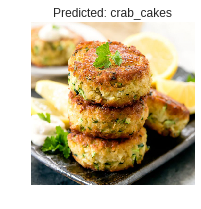

In [0]:
# Crab cakes again!

test_image(test_path/'test_1.jpg')

Probability: tensor(0.9989)


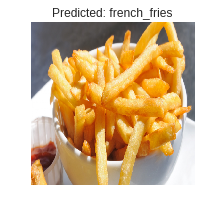

In [0]:
# Yes, that's french fries! Yummm!

test_image(test_path/'test_2.jpg')

Probability: tensor(1.0000)


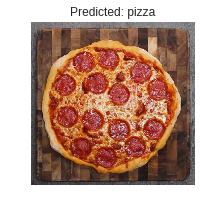

In [0]:
# In this universe, it's called pizza! Correct!

test_image(test_path/'test_3.jpg')

Probability: tensor(0.9999)


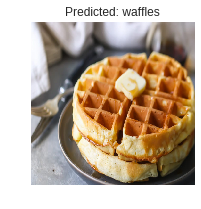

In [0]:
# yup, surely, it's waffles!

test_image(test_path/'test_4.jpg')

Probability: tensor(0.9862)


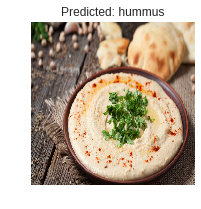

In [0]:
# Hmm, so it's called hummus!

test_image(test_path/'test-5.jpg')